First Model : classical markovian process

The goal here is to model a simple markovian process :
    - one particle (the sytem)
    - 10 states that the system can occupy
    - a (stochastic) transition matrix
    - discrete time
    - UI and diplay capabilities

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable # for plt.colorbar axes positionning
import os

Source code :

In [2]:
def toCumulative(tab) :
    """input : 1D array where all value add-up to 1 (only positive)    ex : [0.1, 0.2, 0.15, 0.55]
    output : 1D array where these value progressively add-up           ex : [0.1, 0.3, 0.45, 1.0]"""
    for i in range(1,len(tab)) :
        tab[i] += tab[i-1]
    return tab




def buildMatrix(n_states, type='uni') :
    """builds a stochastic matrix, each coefficient is drawn randomly
        uni --> uniformly in [0, 1[
        mfd --> mean field (all coef. equal to 1/n_states)
        bin --> binomial (1 sample)
        pow --> power-tail law (Pareto here)
        nrm --> normal law
        ssr --> ssr process (with state no <-> energy)"""
    matrix = np.zeros((n_states,n_states), dtype=float)
    if type=='ssr' :
        for j in range(2,n_states) :
            for i in range(j) : # coefficients are non-zero only if i<j
                matrix[i,j] = 1/(j-1)
        matrix[-1,0] = 1
        matrix[0,1] = 1
    else :
        for j in range(n_states) :
            s = 0
            for i in range(n_states) :
                if   type=='mfd' : rate = 1./n_states
                elif type=='uni' : rate = np.random.uniform()
                elif type=='bin' : rate = np.random.binomial(1,0.5)
                elif type=='pow' : rate = np.random.pareto(0.5)
                elif type=='nrm' : rate = np.abs(np.random.normal()) # ! the coefficients must be postive !
                else :
                    print('DynamicalRule.initialize ERROR : unknown distribution\n Reminder :\n    uni --> uniformly in [0, 1[\n    bin --> binomial (1 sample)\n    pow --> power-tail law (Pareto here)\n    nrm --> normal law')
                    rate = np.random.uniform()
                matrix[i,j] = rate
                if i != j : s += rate
            matrix[j,j] = - s # s is the sum of all other transition rates : the matrix is thus stochastic
    return matrix


def loadSim(path=None) :
    """load a full simulation and returns the object"""
    # getting path
    if path == None :
        current = os.getcwd()
        print('Current directory : ' + current)
        path = str(input('\nEnter path+filename : '))
    # loading
    data = np.load(path + '_data')
    matrix = np.load(path + '_matrix')
    meta = np.load(path + '_meta')
    start_state, n_jumps = int(meta[0]), int(meta[1])
    n_states = np.shape(matrix)[0]
    sim = Simulation(n_jumps, n_states)
    sim.ag.dynamic.setMatrix(matrix)
    sim.data = data
    sim.meta = meta
    print('\Sim loaded from :\n    ' + path.rsplit(sep='/')[-1] + '_data.npy\n'  + path.rsplit(sep='/')[-1] + '_matrix.npy\n    ' + path.rsplit(sep='/')[-1] + '_meta.npy' )

    return sim

def loadInput(path=None) :
    # getting path
    if path == None :
        current = os.getcwd()
        print('Current directory : ' + current)
        path = str(input('\nEnter path+filename : '))
    # loading
    matrix = np.load(path + '_matrix')
    meta = np.load(path + '_meta')
    start_state, n_jumps = int(meta[0]), int(meta[1])
    n_states = np.shape(matrix)[0]
    sim = Simulation(n_jumps, n_states)
    sim.ag.dynamic.setMatrix(matrix)
    sim.meta = meta
    print('\Input loaded from :\n    ' + path.rsplit(sep='/')[-1] + '_matrix.npy\n    ' + path.rsplit(sep='/')[-1] + '_meta.npy' )
    return sim

class DynamicRule:
    """a class that describe the dynamic rule of a simple 10-state system"""

    def __init__(self, n_states) :
        """input : number of state the dynamic should include (size of the matrix)"""
        self.n_states = n_states
        self.matrix = np.zeros((n_states,n_states), dtype=float)
        self.start_state = 0
        self.date = 0.
        return


    def setMatrix(self, matrix) :
        if np.shape(matrix)[0] == self.n_states :
            self.matrix = matrix
        else :
            print('DynamicRule.setMatrix ERROR : input matrix of wrong size.\nMatrix left unchanged.')
        return

    def buildMatrix(n_states, type='uni') :
        """builds a stochastic matrix, each coefficient is drawn randomly
            uni --> uniformly in [0, 1[
            mfd --> mean field (all coef. equal to 1/n_states)
            bin --> binomial (1 sample)
            pow --> power-tail law (Pareto here)
            nrm --> normal law
            ssr --> ssr process (with state no <-> energy)"""
        if type=='ssr' :
            matrix = np.zeros((n_states,n_states), dtype=float)
            for j in range(2,n_states) :
                for i in range(j) : # coefficients are non-zero only if i<j
                    matrix[i,j] = 1/(j-1)
            matrix[-1,0] = 1
            matrix[0,1] = 1
        else :
            for j in range(n_states) :
                s = 0
                for i in range(n_states) :
                    if   type=='mfd' : rate = 1./n_states
                    elif type=='uni' : rate = np.random.uniform()
                    elif type=='bin' : rate = np.random.binomial(1,0.5)
                    elif type=='pow' : rate = np.random.pareto(0.5)
                    elif type=='nrm' : rate = np.abs(np.random.normal()) # ! the coefficients must be postive !
                    else :
                        print('DynamicalRule.initialize ERROR : unknown distribution\n Reminder :\n    uni --> uniformly in [0, 1[\n    bin --> binomial (1 sample)\n    pow --> power-tail law (Pareto here)\n    nrm --> normal law')
                        rate = np.random.uniform()
                    matrix[i,j] = rate
                    if i != j : s += rate
                matrix[j,j] = - s # s is the sum of all other transition rates : the matrix is thus stochastic
        return matrix









class Agent:
    """a class that simulates an agent that evolves accordingly to the markovian dynamic defined by DynamicalRule"""

    def __init__(self, n_states) :
        """input : number of states modeled by the dynamic"""
        self.dynamic = DynamicRule(n_states)
        self.state = self.dynamic.start_state
        self.states = [self.state]
        self.transition_dates = [0.0]
        return

    def initialize(self) :
        """creates the matrix of the dynamic rule"""
        mat = buildMatrix(self.dynamic.n_states, 'uni')
        self.dynamic.setMatrix(mat)
        return

    def doStep(self) :
        """samples the next state, then sample the time it will take to jump
        works also when some coefficient are null"""
        # creating a probability distribution from the rates
        rates = list(self.dynamic.matrix[:,self.state])
        rates.pop(self.state) # taking the lists of rate(i,i0) only when i != i0
        probs = rates/np.sum(rates)
        # calculate what will be the next state
        ind = np.argwhere(np.random.multinomial(1,probs))[0,0]
        if self.state <= ind :
            self.state = ind+1
        else :
            self.state = ind
        self.states.append(self.state)
        # calculate the time of the transition to that state
        delta = np.random.exponential(rates[ind])
        self.dynamic.date += delta
        self.transition_dates.append(self.dynamic.date)
        return















class Simulation:

    def __init__(self, n_jumps = 20, n_states = 5) :
        """data and metadata format :
        meta = [start state, number of jumps that will be simulated]
        data = [[t0=0   , t1     , t2     , ..., t_n    ],
                [state_0, state_1, state_2, ..., state_n]]
        ! Simulation.ag.dynamic.matrix is also part of the metadata !"""
        self.ag = Agent(n_states)
        self.ag.initialize()
        self.meta = np.array([0, n_jumps]) # start state and desired length of simulation (in jumps)
        self.data = np.zeros((2, n_jumps))
        return

    def run(self) :
        """runs the simulation for the indicated number of jumps"""
        n_jumps = self.meta[1]
        for i in range(n_jumps) :
            self.ag.doStep()
        self.data = np.array([self.ag.transition_dates, self.ag.states])
        return

    def plotHistogram(self, log=False) :
        """plot the histogram of occupancy in each state
        log=True for log-scale"""
        # goes through the trajectory of the system and adds the trappig time at each step to the right bin
        hist = np.zeros(self.ag.dynamic.n_states)
        current_s = int(self.data[1,0])
        for i in range(1,len(self.data[0])) :
            hist[current_s] += self.data[0,i]-self.data[0,i-1]
            current_s = int(self.data[1,i])
        # normalizing
        hist = hist/np.sum(hist)
        # plotting
        Xs = np.arange(self.ag.dynamic.n_states)
        plt.bar(Xs, hist)
        plt.xlabel('state')
        plt.ylabel('relative time spent')
        # placing ticks on axes
        if self.ag.dynamic.n_states and not log <= 15 :
            plt.xticks(Xs)
        # setting an eventual log scale
        if log :
            plt.xscale('log')
            plt.yscale('log')
        plt.show()
        return


    def plotTrajectory(self) :
        """plots the trajectory of the system over the phase space"""
        # building additionnal points (state just before each jump)
        l = len(self.data[0])
        Xs = np.zeros(2*l)
        Ys = np.zeros(2*l)
        for i in range(l-1) :
            Xs[2*i], Xs[2*i+1] = self.data[0,i], self.data[0,i+1]
            Ys[2*i], Ys[2*i+1] = self.data[1,i], self.data[1,i]
        i = l-1
        Xs[2*i], Xs[2*i+1] = self.data[0,i], self.data[0,i]*1.05
        Ys[2*i], Ys[2*i+1] = self.data[1,i], self.data[1,i]
        # plotting
        plt.plot(Xs, Ys)
        plt.xlabel('time')
        plt.ylabel('states')
        plt.text(0.9*np.amax(Xs), 0.9*np.amax(Ys), str(int(l-1)) + ' jumps')
        plt.grid(axis='y')
        plt.yticks(np.arange(self.ag.dynamic.n_states))
        plt.show()
        return

    def plotMatrix(self) :
        """plots the driving matrix of the simulation as a colormap"""
        # show matrix
        ax = plt.subplot()
        im = ax.matshow(self.ag.dynamic.matrix)
        # set colorbar (scale) next to matrix
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)
        # show
        plt.show()
        return

    def live(self) :
        """runs the simulation live (interactively)"""
        pass



    def saveSim(self, path) :
        """saves the data, the metadata and the matrix to the path"""
        # getting path
        if path == None :
            current = os.getcwd()
            print('Current directory : ' + current)
            path = str(input('\nEnter path+filename : '))
        # saving
        np.save(path + '_data', self.data)
        np.save(path + '_matrix', self.ag.dynamic.matrix)
        np.save(path + '_meta', self.meta)
        print('\Sim saved as :\n    ' + path.rsplit(sep='/')[-1] + '_data.npy\n    '+ path.rsplit(sep='/')[-1] + '_matrix.npy\n    ' + path.rsplit(sep='/')[-1] + '_meta.npy' )

        return

    def saveInput(self, inpt, path=None) :
        """saves only the matrix and the metadata"""
        # getting path
        if path == None :
            current = os.getcwd()
            print('Current directory : ' + current)
            path = str(input('\nEnter path+filename : '))
        # saving
        np.save(path + '_matrix', self.ag.dynamic.matrix)
        np.save(path + '_meta', self.meta)
        print('\Input saved as :\n    ' + path.rsplit(sep='/')[-1] + '_matrix.npy\n    ' + path.rsplit(sep='/')[-1] + '_meta.npy' )
        return

Testing utilities

In [3]:
# Test 1 : testing DynamicRule
dyn = DynamicRule(5)
dyn.setMatrix(buildMatrix(5,'uni'))
print(dyn.matrix)

[[-1.61970051  0.45033042  0.77879047  0.57926643  0.9871147 ]
 [ 0.1693095  -2.18119207  0.21495433  0.92648403  0.8705443 ]
 [ 0.2169816   0.59719879 -2.63377083  0.57665577  0.53200568]
 [ 0.81682821  0.55912068  0.65602883 -2.51436103  0.60584091]
 [ 0.4165812   0.57454217  0.9839972   0.4319548  -2.99550559]]


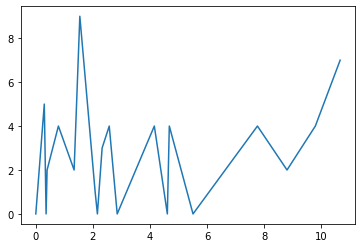

In [4]:
# Test 2 : testing Agent
ag = Agent(10)
ag.initialize()
for i in range(20) :
    ag.doStep()
plt.plot(ag.transition_dates, ag.states)

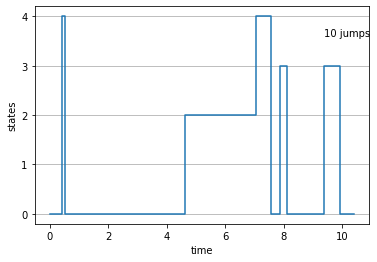

In [5]:
# Test 3 : testing Simulation.run and Simulation.plotTrajectory
sim = Simulation(10)
sim.run()
sim.plotTrajectory()

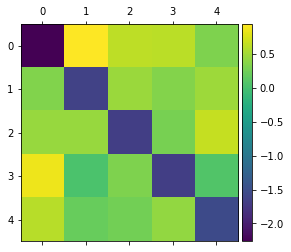

In [6]:
# Test 4 : testing Simulation.plotMatrix
sim = Simulation(10)
sim.plotMatrix()

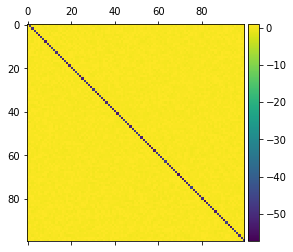

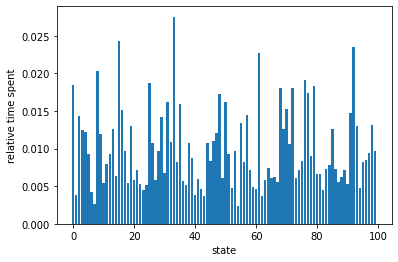

In [7]:
# Test 5 : testing Simulation.plotHistogram
sim = Simulation(n_jumps=1000, n_states=100)
sim.run()
sim.plotMatrix()
sim.plotHistogram()

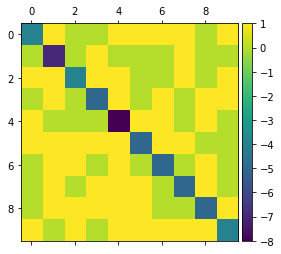

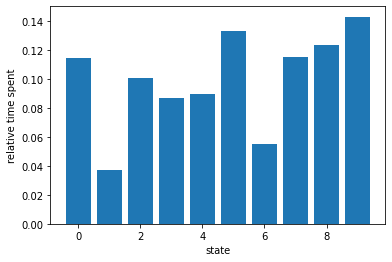

In [8]:
# Test 6 : testing re-initialization of a dyamic
sim = Simulation(n_jumps=1000, n_states=10)
mat = buildMatrix(n_states = 10, type='bin')
sim.ag.dynamic.setMatrix(mat)
sim.run()
sim.plotMatrix()
sim.plotHistogram()

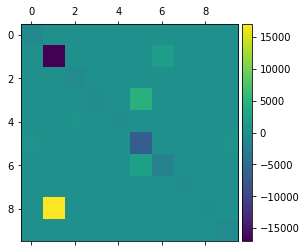

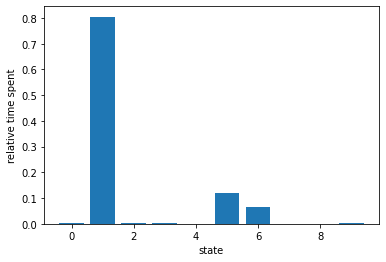

In [9]:
# Test 7 : testing different samplings of driving matrix
sim = Simulation(n_jumps=1000, n_states=10)
mat = buildMatrix(n_states = 10, type='pow')
sim.ag.dynamic.setMatrix(mat)
sim.run()
sim.plotMatrix()
sim.plotHistogram()

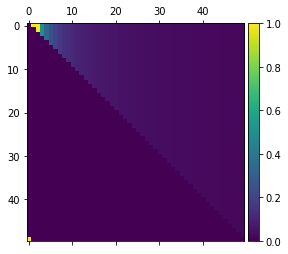

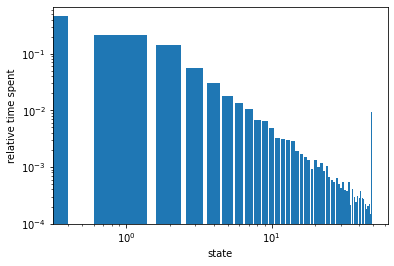

In [10]:
# Test 8 : testing SSR driving matrix and log-scale plotting
sim = Simulation(n_jumps=10000, n_states=50)
mat = buildMatrix(n_states = 50, type='ssr')
sim.ag.dynamic.setMatrix(mat)
sim.run()
sim.plotMatrix()
sim.plotHistogram(log=True)